# Predicting Time to Merge of a Pull Request


In this notebook, we train a time to merge model for the `thoth-station` organization pull request data. For that, we will first create transformer objects (based on the explorations in the previous notebook) to extract features from raw PR data. Then, we will train machine learning models to classify a PR's `time_to_merge` into one of the above 10 bins (or "classes").

Class 0 : < 1 min  
Class 1 : < 2 mins   
Class 2 : < 8 mins    
Class 3 : < 20 mins  
Class 4 : < 1 hr  
Class 5 : < 4 hrs  
Class 6 : < 18 hrs  
Class 7 : < 3 days   
Class 8 : < 21 days   
Class 9: > 3 weeks  


In [122]:
import os
import sys
import boto3
import tempfile
from io import StringIO
import datetime

import joblib
import warnings
from io import BytesIO
from copy import deepcopy

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from dotenv import load_dotenv, find_dotenv

from src.features.build_features import (
    DateTimeDetailsTransformer,
    NumChangedFilesTransformer,
    StringLenTransformer,
    NumPrevPRsTransformer,
    FileTypeCountTransformer,
    TitleWordCountTransformer,
)

metric_template_path = "../../../notebooks/data-sources/TestGrid/metrics"
if metric_template_path not in sys.path:
    sys.path.insert(1, metric_template_path)

from ipynb.fs.defs.metric_template import (  # noqa: E402
    CephCommunication,  # noqa: E402
)  # noqa: E402

In [123]:
warnings.filterwarnings("ignore")
load_dotenv(find_dotenv())

True

## Get Raw Data

In [124]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = "github"
REMOTE = os.getenv("REMOTE")
data_path = "../../data/raw/GitHub/thoth_PR_data.csv"

In [125]:
if REMOTE:
    print("getting dataset from ceph")
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    s3_object = cc.s3_resource.Object(s3_bucket, "thoth_PR_data.csv")
    file = s3_object.get()["Body"].read().decode("utf-8")

pr_df = pd.read_csv(StringIO(file))

getting dataset from ceph


In [126]:
pr_df.head()

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,org,repo,index
0,0,0,678.0,Automatic update of base-image in CI,Automatic update of base-image in CI.,XS,sesheta,2022-05-09 19:38:22,2022-05-09 19:43:18,harshad16,...,{'sesheta': 210},"{'966742282': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/XS', 'ok-to-test']",['1a643bbdf0304b1d7b94e374680901765bb695c1'],['.aicoe-ci.yaml'],2022-05-09 19:38:24,2022-05-09 19:38:24,thoth-station,graph-refresh-job,NaN
1,1,1,677.0,Release of version 0.3.19,"Hey, @harshad16!\n\nOpening this PR to fix the...",XS,khebhut[bot],2022-05-09 19:36:51,2022-05-09 19:43:05,harshad16,...,{'sesheta': 252},"{'966740804': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/XS', 'bot', 'needs-ok-to-te...",['050ed88f0b7b0dcaa94ea082d5a1a34862d59848'],"['CHANGELOG.md', 'version.py']",2022-05-09 19:36:53,2022-05-09 19:36:53,thoth-station,graph-refresh-job,NaN
2,2,2,675.0,Automatic update of base-image in CI,Automatic update of base-image in CI.,XS,sesheta,2022-05-09 18:44:54,2022-05-09 19:23:46,harshad16,...,{'sesheta': 447},"{'966683048': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/XS', 'ok-to-test']",['1a643bbdf0304b1d7b94e374680901765bb695c1'],['.aicoe-ci.yaml'],2022-05-09 18:44:57,2022-05-09 18:44:57,thoth-station,graph-refresh-job,NaN
3,3,3,674.0,Automatic update of dependencies by Kebechet f...,Kebechet has updated the dependencies to the l...,L,khebhut[bot],2022-05-09 18:44:08,2022-05-09 19:23:27,harshad16,...,{'sesheta': 429},"{'966682266': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/L', 'bot', 'needs-ok-to-tes...",['39c9414fdd8575bfa55d2e51ecab3639f42f40da'],['Pipfile.lock'],2022-05-09 18:44:10,2022-05-09 18:44:10,thoth-station,graph-refresh-job,NaN
4,4,4,672.0,Automatic update of dependencies by Kebechet f...,Kebechet has updated the dependencies to the l...,L,khebhut[bot],2022-02-24 17:42:22,2022-02-24 18:11:28,sesheta,...,{'sesheta': 257},"{'892779373': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/L', 'bot', 'needs-ok-to-tes...",['d06965a0ab7c603b9adb8dbc747b47e963209a8f'],['Pipfile.lock'],2022-02-24 17:42:25,2022-02-24 17:42:25,thoth-station,graph-refresh-job,NaN


In [127]:
# remove PRs from train/test which are still open
pr_df = pr_df[pr_df["closed_at"].notna()]
pr_df = pr_df[pr_df["merged_at"].notna()]

In [128]:
pr_df["created_at"] = pr_df["created_at"].apply(
    lambda x: int(datetime.datetime.timestamp(pd.to_datetime(x)))
)
pr_df["closed_at"] = pr_df["closed_at"].apply(
    lambda x: int(datetime.datetime.timestamp(pd.to_datetime(x)))
)
pr_df["merged_at"] = pr_df["merged_at"].apply(
    lambda x: int(datetime.datetime.timestamp(pd.to_datetime(x)))
)

In [129]:
pr_df.head()

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,org,repo,index
0,0,0,678.0,Automatic update of base-image in CI,Automatic update of base-image in CI.,XS,sesheta,1652125102,1652125398,harshad16,...,{'sesheta': 210},"{'966742282': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/XS', 'ok-to-test']",['1a643bbdf0304b1d7b94e374680901765bb695c1'],['.aicoe-ci.yaml'],2022-05-09 19:38:24,2022-05-09 19:38:24,thoth-station,graph-refresh-job,NaN
1,1,1,677.0,Release of version 0.3.19,"Hey, @harshad16!\n\nOpening this PR to fix the...",XS,khebhut[bot],1652125011,1652125385,harshad16,...,{'sesheta': 252},"{'966740804': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/XS', 'bot', 'needs-ok-to-te...",['050ed88f0b7b0dcaa94ea082d5a1a34862d59848'],"['CHANGELOG.md', 'version.py']",2022-05-09 19:36:53,2022-05-09 19:36:53,thoth-station,graph-refresh-job,NaN
2,2,2,675.0,Automatic update of base-image in CI,Automatic update of base-image in CI.,XS,sesheta,1652121894,1652124226,harshad16,...,{'sesheta': 447},"{'966683048': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/XS', 'ok-to-test']",['1a643bbdf0304b1d7b94e374680901765bb695c1'],['.aicoe-ci.yaml'],2022-05-09 18:44:57,2022-05-09 18:44:57,thoth-station,graph-refresh-job,NaN
3,3,3,674.0,Automatic update of dependencies by Kebechet f...,Kebechet has updated the dependencies to the l...,L,khebhut[bot],1652121848,1652124207,harshad16,...,{'sesheta': 429},"{'966682266': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/L', 'bot', 'needs-ok-to-tes...",['39c9414fdd8575bfa55d2e51ecab3639f42f40da'],['Pipfile.lock'],2022-05-09 18:44:10,2022-05-09 18:44:10,thoth-station,graph-refresh-job,NaN
4,4,4,672.0,Automatic update of dependencies by Kebechet f...,Kebechet has updated the dependencies to the l...,L,khebhut[bot],1645724542,1645726288,sesheta,...,{'sesheta': 257},"{'892779373': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/L', 'bot', 'needs-ok-to-tes...",['d06965a0ab7c603b9adb8dbc747b47e963209a8f'],['Pipfile.lock'],2022-02-24 17:42:25,2022-02-24 17:42:25,thoth-station,graph-refresh-job,NaN


## Extract Labels from Raw Data

In [132]:
def get_ttm_class(ttm):
    """
    Assign a ttm "class" / "category" / "bin" to the input numerical ttm value
    E.g. if the time to merge was 1 hours, this function will return
    class "5" which represents "merged in 0.5-2 hours"
    """
    if ttm < 0.00166:
        return 0
    elif ttm < 0.03333:
        return 1
    elif ttm < 0.13333:
        return 2
    elif ttm < 0.33333:
        return 3
    elif ttm < 1:
        return 4
    elif ttm < 4:
        return 5
    elif ttm < 18:
        return 6
    elif ttm < 72:
        return 7
    elif ttm < 504:
        return 8
    else:
        return 9


y = (pr_df["merged_at"] - pr_df["created_at"]).astype("float")
y = y.dropna()
y = (y / 3600).apply(get_ttm_class)
y

0        2
1        2
2        4
3        4
4        4
        ..
46960    7
46961    7
46962    8
46963    8
46965    7
Length: 43594, dtype: int64

In [133]:
pr_df.head()

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,org,repo,index
0,0,0,678.0,Automatic update of base-image in CI,Automatic update of base-image in CI.,XS,sesheta,1652125102,1652125398,harshad16,...,{'sesheta': 210},"{'966742282': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/XS', 'ok-to-test']",['1a643bbdf0304b1d7b94e374680901765bb695c1'],['.aicoe-ci.yaml'],2022-05-09 19:38:24,2022-05-09 19:38:24,thoth-station,graph-refresh-job,NaN
1,1,1,677.0,Release of version 0.3.19,"Hey, @harshad16!\n\nOpening this PR to fix the...",XS,khebhut[bot],1652125011,1652125385,harshad16,...,{'sesheta': 252},"{'966740804': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/XS', 'bot', 'needs-ok-to-te...",['050ed88f0b7b0dcaa94ea082d5a1a34862d59848'],"['CHANGELOG.md', 'version.py']",2022-05-09 19:36:53,2022-05-09 19:36:53,thoth-station,graph-refresh-job,NaN
2,2,2,675.0,Automatic update of base-image in CI,Automatic update of base-image in CI.,XS,sesheta,1652121894,1652124226,harshad16,...,{'sesheta': 447},"{'966683048': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/XS', 'ok-to-test']",['1a643bbdf0304b1d7b94e374680901765bb695c1'],['.aicoe-ci.yaml'],2022-05-09 18:44:57,2022-05-09 18:44:57,thoth-station,graph-refresh-job,NaN
3,3,3,674.0,Automatic update of dependencies by Kebechet f...,Kebechet has updated the dependencies to the l...,L,khebhut[bot],1652121848,1652124207,harshad16,...,{'sesheta': 429},"{'966682266': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/L', 'bot', 'needs-ok-to-tes...",['39c9414fdd8575bfa55d2e51ecab3639f42f40da'],['Pipfile.lock'],2022-05-09 18:44:10,2022-05-09 18:44:10,thoth-station,graph-refresh-job,NaN
4,4,4,672.0,Automatic update of dependencies by Kebechet f...,Kebechet has updated the dependencies to the l...,L,khebhut[bot],1645724542,1645726288,sesheta,...,{'sesheta': 257},"{'892779373': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/L', 'bot', 'needs-ok-to-tes...",['d06965a0ab7c603b9adb8dbc747b47e963209a8f'],['Pipfile.lock'],2022-02-24 17:42:25,2022-02-24 17:42:25,thoth-station,graph-refresh-job,NaN


## Extract Features from Raw Data

In this section, we will create transformer objects to process raw data as per the feature extraction methods that were found to be the most effective in the previous EDA notebook.

To ensure that joblib serializes the custom transformer objects correctly, we will write their definitions in [`src/features/build_features.py`](../../src/features/build_features.py) instead of this notebook, and import them from the `src` package. This way, the `src` package can be listed as a dependency wherever these objects need to be deserialized (for example, Seldon server).

#### size

In [134]:
# map values to 0,1,2,3,4,5
pr_size_encoder = OrdinalEncoder(categories=[["XS", "S", "M", "L", "XL", "XXL"]])

#### created_at

In [135]:
# get day, month, date, etc. from a unix timestamp
dt_details_transf = DateTimeDetailsTransformer()

#### changed_files_number

In [136]:
# number of files changed in PR
n_changed_files_transf = NumChangedFilesTransformer()

#### body_size

In [137]:
# number of characters in PR description
body_size_transf = StringLenTransformer("body")

#### num_previous_merged_prs

In [138]:
# number of PRs that the creator of this PR has previously contributed
n_prev_prs_transf = NumPrevPRsTransformer()

#### filetype_\<type>

In [139]:
# how many files of the given extension were changed in PR
FILE_EXTENSIONS_TO_COUNT = ["None"]

ftype_count_transf = FileTypeCountTransformer(file_extensions=FILE_EXTENSIONS_TO_COUNT)

#### title_wordcount_\<word>

In [140]:
# how many times these words appeared in PR title
WORDS_TO_COUNT = [
    "add",
    "adviser",
    "amun",
    "api",
    "bump",
    "certs",
    "cluster",
    "deployment",
    "environment",
    "exporter",
    "feature",
    "fix",
    "functions",
    "graph",
    "implement",
    "increase",
    "ingestion",
    "introduce",
    "investigator",
    "kustomize",
    "management",
    "middletier",
    "notebook",
    "parallelism",
    "patch",
    "prod",
    "pyproject",
    "python",
    "reporter",
    "required",
    "revert",
    "revsolver",
    "role",
    "s",
    "scorecards",
    "secrets",
    "services",
    "slo",
    "stage",
    "toml",
    "upgrade",
    "v0",
    "v1",
    "v2021",
    "version",
    "wip",
    "💊",
]

title_wc_transf = TitleWordCountTransformer(words=WORDS_TO_COUNT)

## Apply Transforms

In [141]:
# FIXME: breaks if not sorted. can we shave off some runtime by not requiring to sort?
pr_df = pr_df.sort_values(by="created_at")

In [142]:
pr_df

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,org,repo,index
43545,214,214,1.0,removed the janusgraph template due to new loc...,this file is now located at https://raw.github...,M,goern,1519911,1520098,fridex,...,{'fridex': 13},{},[],['026ec1a944e25bc8a0db109eff63a708e489b6b2'],['openshift/janusgraph.yaml'],NaN,NaN,thoth-station,core,NaN
43544,213,213,2.0,Download janusgraph template on deployment,Related: #1,XS,fridex,1520098,1520099,fridex,...,"{'fridex': 3, 'goern': 2}",{},[],['ed9b60ab277cc72bd489d4d1fa651561c56b97cf'],"['.gitignore', 'openshift/deploy.sh']",NaN,NaN,thoth-station,core,NaN
43543,212,212,3.0,this is template cleanup and jenkins pipeline,... :),XXL,goern,1521813,1522835,fridex,...,"{'fridex': 102, 'goern': 5}","{'106838621': {'author': 'fridex', 'words_coun...",[],"['ced49067e21ee30d8f77a1003d13e3d01c803855', '...","['.gitignore', 'Jenkinsfile', 'README.rst', 'o...",1970-01-18 14:47:38.236,NaN,thoth-station,core,NaN
43540,209,209,6.0,Respect logging configuration in env variables,NaN,S,fridex,1522998,1524230,sesheta,...,"{'fridex': 15, 'goern': 2}","{'110792359': {'author': 'goern', 'words_count...",['approved'],['d86eab7718d0d180f8435d4082707f5c31b475c9'],"['openshift/configmap-template.yaml', 'openshi...",1970-01-18 15:09:19.370,1970-01-18 15:09:19.370,thoth-station,core,NaN
34520,223,223,2.0,adding OpenShift buildConfig template,NaN,M,goern,1523524,1523690,fridex,...,{},"{'112200224': {'author': 'fridex', 'words_coun...",[],"['f9ecaefa92fa097dc440265dd9584adb6c125dd4', '...",['openshift/buildConfig-template.yaml'],2018-04-14 07:28:17.000,2018-04-14 07:28:17.000,thoth-station,cleanup-job,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35437,1,1,158.0,Fix username in maintainers,## Related Issues and Dependencies\r\n\r\nRela...,XS,mayaCostantini,1653315907,1653316728,harshad16,...,{'sesheta': 73},{},['size/XS'],"['d9463592fdadf859a391606dc36d8bdfc5133964', '...",['OWNERS'],NaN,NaN,thoth-station,prescriptions-refresh-job,NaN
35436,0,0,161.0,Release of version 0.7.0,"Hey, @harshad16!\n\nOpening this PR to create ...",M,khebhut[bot],1653318142,1653318970,sesheta,...,{'sesheta': 327},"{'981924248': {'author': 'sefkhet-abwy[bot]', ...","['bot', 'size/M', 'needs-ok-to-test', 'approve...",['4362562c5d91520fd2aec782c56c474ab664c25a'],"['CHANGELOG.md', 'thoth/prescriptions_refresh/...",2022-05-23 15:02:24,2022-05-23 15:02:24,thoth-station,prescriptions-refresh-job,NaN
1270,2,2,2639.0,added option for starts_with filter on /python...,## Related Issues and Dependencies\r\nhttps://...,S,Gkrumbach07,1653326617,1653391278,mayaCostantini,...,{'sesheta': 85},"{'982657137': {'author': 'mayaCostantini', 'wo...",['size/S'],['ffbaf180aecc5688ccbb1ea08fcc23646f075807'],['thoth/storages/graph/postgres.py'],2022-05-24 06:30:15,2022-05-24 06:30:15,thoth-station,storages,NaN
1268,0,0,2642.0,Release of version 0.72.2,"Hey, @mayaCostantini!\n\nOpening this PR to fi...",XS,khebhut[bot],1653391721,1653392170,mayaCostantini,...,{},{},['bot'],['d23ba576d5d892c74260c44fb855b4029c17c1af'],"['CHANGELOG.md', 'thoth/storages/__init__.py']",NaN,NaN,thoth-station,storages,NaN


In [173]:
pr_df.index

Int64Index([43545, 43544, 43543, 43540, 34520, 43538, 34519, 43537, 43536,
            43535,
            ...
            24007, 35346, 36333, 36332, 35438, 35437, 35436,  1270,  1268,
             3458],
           dtype='int64', length=43594)

In [174]:
len(pr_df.index)

43594

In [175]:
max(pr_df.index)

46965

In [143]:
# transformer objects compiled into one columntransformer
raw_data_processor = ColumnTransformer(
    [
        ("pr_size", pr_size_encoder, ["size"]),  # 1 cols generated
        ("created_at_details", dt_details_transf, ["created_at"]),  # 4 cols generated
        (
            "n_changed_files",
            n_changed_files_transf,
            ["changed_files_number"],
        ),  # 1 cols generated
        ("body_size", body_size_transf, ["body"]),  # 1 cols generated
        ("n_prev_prs", n_prev_prs_transf, ["created_by"]),  # 1 cols generated
        ("n_commits", "passthrough", ["commits_number"]),  # 1 cols generated
        (
            "filetype_counter",
            ftype_count_transf,
            ["changed_files"],
        ),  # 2 cols generated
        ("title_word_counter", title_wc_transf, ["title"]),  # 15 cols generated
    ],
    remainder="drop",
)

In [144]:
# column names. this is needed because sklearn forcefully converts df to ndarray,
# thus losing column information. this is a hack to retain that info. look for alternatives
cols = (
    [
        "size",
        "created_at_day",
        "created_at_month",
        "created_at_weekday",
        "created_at_hour",
    ]
    + [
        "changed_files_number",
        "body_size",
        "num_prev_merged_prs",
        "commits_number",
    ]
    + [f"filetype_{f}" for f in FILE_EXTENSIONS_TO_COUNT]
    + [f"title_wordcount_{w}" for w in WORDS_TO_COUNT]
)

In [145]:
X = raw_data_processor.fit_transform(pr_df)
X

array([[ 2., 18.,  1., ...,  0.,  0.,  0.],
       [ 0., 18.,  1., ...,  0.,  0.,  0.],
       [ 5., 18.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 1., 23.,  5., ...,  0.,  0.,  0.],
       [ 0., 24.,  5., ...,  1.,  0.,  0.],
       [ 0., 24.,  5., ...,  0.,  0.,  0.]])

In [146]:
X = pd.DataFrame(X, index=pr_df.index, columns=cols)
X

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,num_prev_merged_prs,commits_number,filetype_None,...,title_wordcount_slo,title_wordcount_stage,title_wordcount_toml,title_wordcount_upgrade,title_wordcount_v0,title_wordcount_v1,title_wordcount_v2021,title_wordcount_version,title_wordcount_wip,title_wordcount_💊
43545,2.0,18.0,1.0,6.0,14.0,1.0,7.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43544,0.0,18.0,1.0,6.0,14.0,2.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43543,5.0,18.0,1.0,6.0,14.0,12.0,2.0,1.0,14.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43540,1.0,18.0,1.0,6.0,15.0,2.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34520,2.0,18.0,1.0,6.0,15.0,1.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35437,0.0,23.0,5.0,0.0,14.0,1.0,8.0,195.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35436,2.0,23.0,5.0,0.0,15.0,2.0,264.0,25953.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1270,1.0,23.0,5.0,0.0,17.0,1.0,91.0,66.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1268,0.0,24.0,5.0,1.0,11.0,2.0,37.0,25954.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [167]:
p1 = X.reindex(X_test.index)

## Drop NA + Train/Test Split

In [147]:
y

0        2
1        2
2        4
3        4
4        4
        ..
46960    7
46961    7
46962    8
46963    8
46965    7
Length: 43594, dtype: int64

In [176]:
y.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            46953, 46956, 46957, 46958, 46959, 46960, 46961, 46962, 46963,
            46965],
           dtype='int64', length=43594)

In [152]:
# drop entries for which labels are unknown
# also make sure labels and features are consistent
X = X.reindex(y.index)

In [177]:
set(X.index) == set(y.index)

True

In [178]:
len(X)

43594

In [179]:
X

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,num_prev_merged_prs,commits_number,filetype_None,...,title_wordcount_slo,title_wordcount_stage,title_wordcount_toml,title_wordcount_upgrade,title_wordcount_v0,title_wordcount_v1,title_wordcount_v2021,title_wordcount_version,title_wordcount_wip,title_wordcount_💊
0,0.0,9.0,5.0,0.0,19.0,1.0,6.0,7262.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,9.0,5.0,0.0,19.0,2.0,76.0,25324.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,9.0,5.0,0.0,18.0,1.0,6.0,7256.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,9.0,5.0,0.0,18.0,1.0,57.0,25312.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,24.0,2.0,3.0,17.0,1.0,54.0,21162.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46960,0.0,18.0,1.0,1.0,9.0,1.0,9.0,5228.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46961,1.0,29.0,11.0,0.0,10.0,2.0,57.0,20645.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
46962,3.0,15.0,11.0,0.0,16.0,9.0,0.0,4997.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46963,1.0,15.0,11.0,0.0,16.0,3.0,0.0,4996.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [181]:
# upload X_test and y_test to S3 bucket for testing / running sanity check on the model inference service
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)

ret = cc.upload_to_ceph(X_test, s3_path, "X_test.parquet")
print(ret["ResponseMetadata"]["HTTPStatusCode"])

ret = cc.upload_to_ceph(y_test.to_frame("ttm_class"), s3_path, "y_test.parquet")
print(ret["ResponseMetadata"]["HTTPStatusCode"])

200
200


In [182]:
# convert from pandas series to lists to avoid warnings during training
y_train = y_train.to_list()
y_test = y_test.to_list()

## Scale data

In [183]:
X_train

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,num_prev_merged_prs,commits_number,filetype_None,...,title_wordcount_slo,title_wordcount_stage,title_wordcount_toml,title_wordcount_upgrade,title_wordcount_v0,title_wordcount_v1,title_wordcount_v2021,title_wordcount_version,title_wordcount_wip,title_wordcount_💊
4353,1.0,14.0,8.0,2.0,15.0,1.0,14.0,2301.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3598,0.0,18.0,3.0,4.0,1.0,1.0,6.0,7237.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43791,0.0,1.0,3.0,3.0,15.0,1.0,78.0,4.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44224,2.0,10.0,10.0,3.0,9.0,1.0,14.0,2691.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1613,2.0,15.0,1.0,4.0,11.0,1.0,141.0,1063.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6857,2.0,23.0,2.0,6.0,23.0,1.0,14.0,4081.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11905,1.0,19.0,1.0,0.0,21.0,1.0,23.0,5647.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40805,1.0,6.0,11.0,4.0,8.0,1.0,14.0,7033.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
912,1.0,23.0,9.0,2.0,13.0,1.0,0.0,3883.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
X_test

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,num_prev_merged_prs,commits_number,filetype_None,...,title_wordcount_slo,title_wordcount_stage,title_wordcount_toml,title_wordcount_upgrade,title_wordcount_v0,title_wordcount_v1,title_wordcount_v2021,title_wordcount_version,title_wordcount_wip,title_wordcount_💊
4298,2.0,7.0,11.0,3.0,14.0,1.0,14.0,2860.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13316,1.0,19.0,1.0,0.0,21.0,1.0,23.0,4057.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
46056,0.0,19.0,1.0,0.0,15.0,2.0,4.0,135.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2540,3.0,11.0,9.0,2.0,6.0,3.0,0.0,2418.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28650,0.0,1.0,3.0,1.0,11.0,1.0,23.0,21571.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28461,0.0,1.0,3.0,1.0,11.0,1.0,23.0,21755.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39492,1.0,20.0,1.0,0.0,17.0,1.0,14.0,3705.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30436,1.0,16.0,9.0,3.0,22.0,1.0,23.0,19235.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45481,0.0,19.0,1.0,0.0,20.0,1.0,7.0,656.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [160]:
# lets apply a yeo johnson transform to try to make the data more gaussian
scaler = PowerTransformer()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Define Training and Evaluation Pipeline

Here, we will define a function to train a given classifier on the training set and then evaluate it on the test set. 

In [33]:
def train_evaluate_classifier(clf, xtrain, ytrain, xtest, ytest):
    # Train our classifier
    clf.fit(xtrain, ytrain)

    # Make predictions
    preds = clf.predict(xtest)

    # View classification report
    print(classification_report(ytest, preds))

    # Plot confusion matrix heatmap
    plt.figure(figsize=(16, 12))
    cf_matrix = confusion_matrix(ytest, preds)
    group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
    group_percentages = [
        "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]
    box_labels = [
        f"{v1}{v2}".strip() for v1, v2 in zip(group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

    sns.heatmap(cf_matrix, cmap="OrRd", annot=box_labels, fmt="")
    plt.xlabel("Predicted TTM Label")
    plt.ylabel("True TTM Label")
    plt.title("Confusion Matrix Heatmap")

## Define Models and Parameters

Next, we will define and initialize the classifiers that we will be exploring for the time-to-merge prediction task.

### Gaussian Naive Bayes

In [34]:
# Initialize classifier
gnb = GaussianNB()

### SVM

In [35]:
# Initialize classifier
svc = SVC(random_state=42)

### Random Forest

In [36]:
# Initialize classifier
rf = RandomForestClassifier(
    n_estimators=200,
    max_features=0.75,
    random_state=42,
    n_jobs=-1,
)

### XGBoost

In [37]:
# Initialize classifier
xgbc = XGBClassifier(
    n_estimators=125,
    learning_rate=0.1,
    random_state=42,
    verbosity=1,
    n_jobs=-1,
)

## Compare Model Results

Finally, we will run the train all of the classifiers defined above and evaluate their performance. 

### Experiment 1: Train using all features

First, lets train the classifiers using all the engineered features as input.

#### Naive Bayes

              precision    recall  f1-score   support

           0       0.73      0.00      0.01      3194
           1       0.28      0.03      0.05      1163
           2       0.18      0.00      0.01       971
           3       0.20      0.00      0.00       619
           4       0.04      0.22      0.07       445
           5       0.09      0.28      0.13       658
           6       0.00      0.00      0.00       469
           7       0.14      0.00      0.00       754
           8       0.10      0.02      0.03       348
           9       0.02      0.94      0.04        98

    accuracy                           0.05      8719
   macro avg       0.18      0.15      0.04      8719
weighted avg       0.36      0.05      0.03      8719



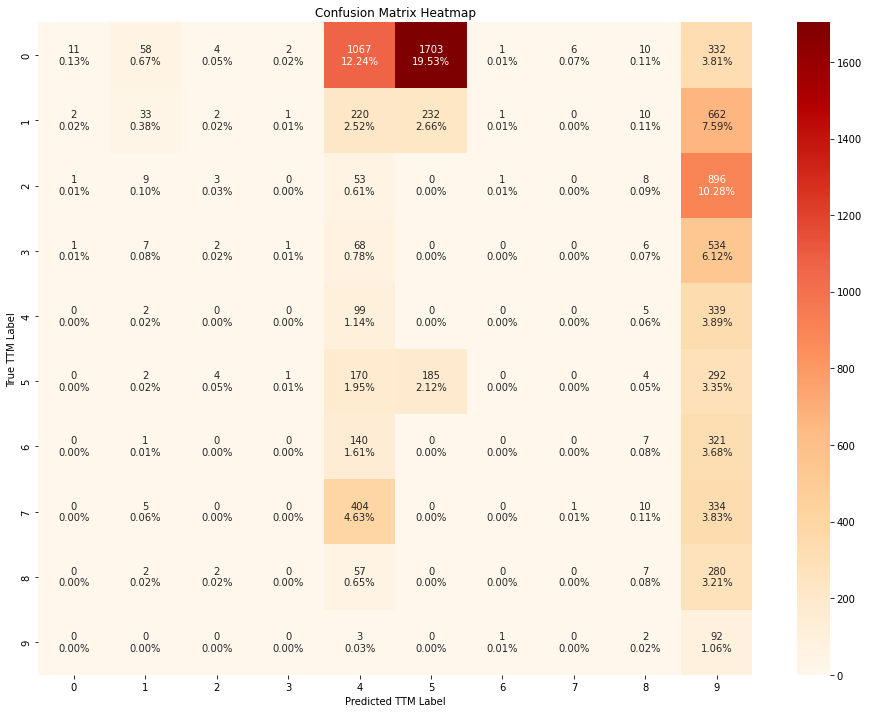

In [38]:
train_evaluate_classifier(gnb, X_train_scaled, y_train, X_test_scaled, y_test)

#### SVM

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      3194
           1       0.57      0.26      0.36      1163
           2       0.33      0.73      0.45       971
           3       0.30      0.18      0.23       619
           4       0.41      0.13      0.20       445
           5       0.67      0.54      0.60       658
           6       0.57      0.36      0.44       469
           7       0.71      0.59      0.64       754
           8       0.31      0.28      0.29       348
           9       0.00      0.00      0.00        98

    accuracy                           0.62      8719
   macro avg       0.47      0.41      0.41      8719
weighted avg       0.62      0.62      0.59      8719



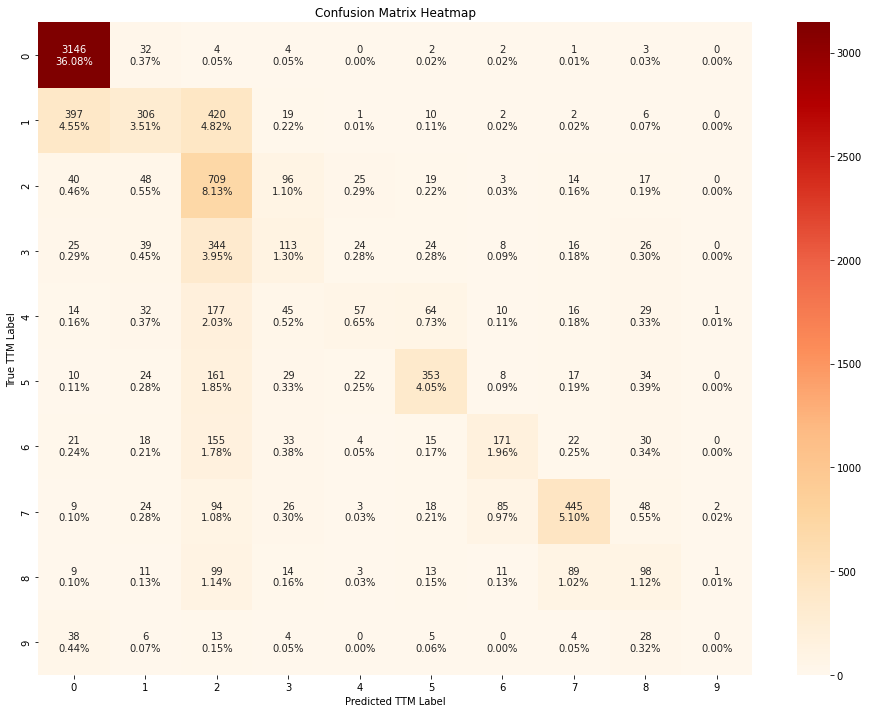

In [39]:
train_evaluate_classifier(svc, X_train_scaled, y_train, X_test_scaled, y_test)

#### Random Forest

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3194
           1       0.73      0.75      0.74      1163
           2       0.54      0.57      0.56       971
           3       0.38      0.40      0.39       619
           4       0.47      0.39      0.43       445
           5       0.66      0.65      0.66       658
           6       0.64      0.61      0.62       469
           7       0.76      0.73      0.74       754
           8       0.44      0.46      0.45       348
           9       0.28      0.16      0.21        98

    accuracy                           0.74      8719
   macro avg       0.59      0.57      0.58      8719
weighted avg       0.73      0.74      0.73      8719



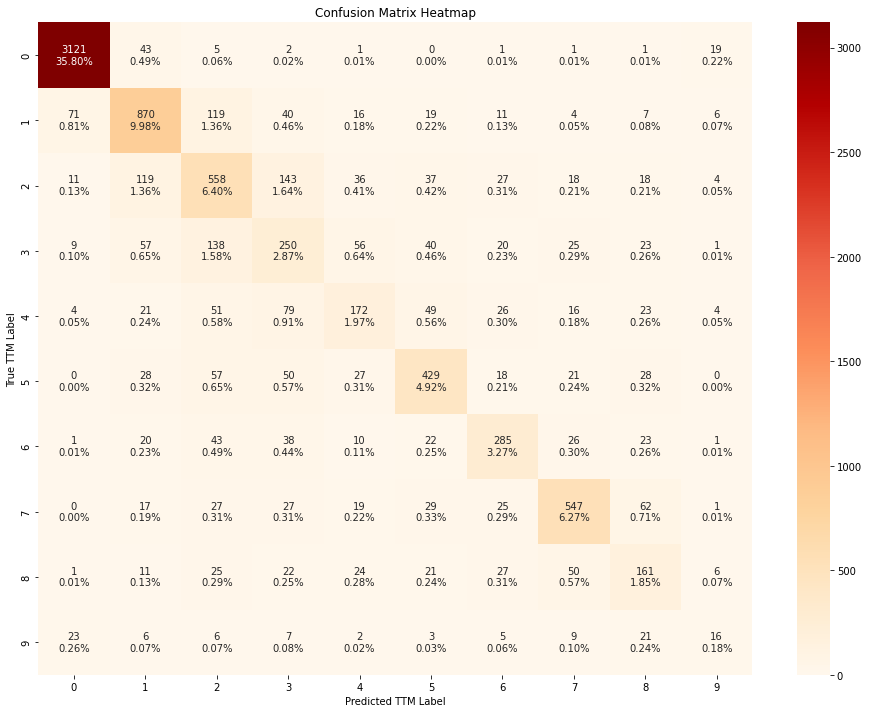

In [40]:
train_evaluate_classifier(rf, X_train_scaled, y_train, X_test_scaled, y_test)

#### XG Boost

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3194
           1       0.67      0.75      0.71      1163
           2       0.51      0.66      0.58       971
           3       0.36      0.36      0.36       619
           4       0.66      0.30      0.42       445
           5       0.64      0.60      0.62       658
           6       0.69      0.53      0.60       469
           7       0.80      0.71      0.75       754
           8       0.47      0.48      0.47       348
           9       0.36      0.14      0.20        98

    accuracy                           0.73      8719
   macro avg       0.61      0.55      0.57      8719
weighted avg       0.73      0.73      0.72      8719



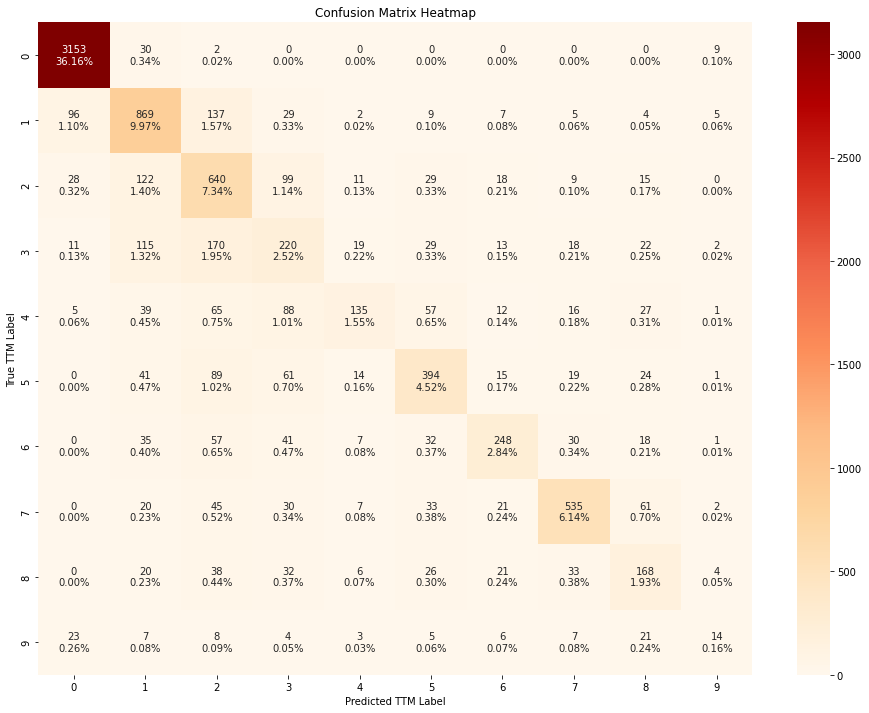

In [41]:
train_evaluate_classifier(xgbc, X_train_scaled, y_train, X_test_scaled, y_test)

Based on the results above, it seems the Naive Bayes performs poorly compared to others, amongst SVM, Random Forest and XGBoost, seems like the Random Forest classifier outperforms all others, followed closely by the XGBoost. The Naive bayes seems to be heavily biased towards a few classes. On the contrary, the random forest SVM and the  XGBoost models seem to be less biased and have mis-classifications within the bordering classes amongst the ordinal classes.

Note that for model deployment (which is the eventual goal), we will also need to include any scaler or preprocessor objects. This is because the input to the inference service will be raw unscaled data. We plan to address this issue by using `sklearn.Pipeline` object to package the preprocessor(s) and model as one "combined" model. Since the random forest performs best here, we will save the random forest as the "best" model here. In the step below, we create a copy of the model so that we can save it to S3 later on and use it for model deployment.

In [42]:
# create a clone (create a copy of the object with the learned weights)
selected_model = deepcopy(rf)

In [43]:
# sanity check
print(classification_report(y_test, selected_model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3194
           1       0.73      0.75      0.74      1163
           2       0.54      0.57      0.56       971
           3       0.38      0.40      0.39       619
           4       0.47      0.39      0.43       445
           5       0.66      0.65      0.66       658
           6       0.64      0.61      0.62       469
           7       0.76      0.73      0.74       754
           8       0.44      0.46      0.45       348
           9       0.28      0.16      0.21        98

    accuracy                           0.74      8719
   macro avg       0.59      0.57      0.58      8719
weighted avg       0.73      0.74      0.73      8719



### Experiment 2: Let's train using pruned features

In the previous notebook we performed some feature engineering and pruned the number of features down. However, it might be possible that further pruning the features based on the importances given to them by the models yields more generalizable and accurate models. So in this section, we will explore using Recursive Feature Elimination (RFE) to rank the features in terms of their importance, and recursively select the best subsets to train our models with.

In [44]:
# use the random forest classifier as the base estimator since it had the highest f1
selector = RFE(rf, n_features_to_select=20, step=5)
selector = selector.fit(X_train_scaled, y_train)

In [45]:
# No of top features to select
top = 20

In [46]:
ranks = selector.ranking_
ranks

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 3, 1, 1, 8, 5, 4, 1, 3, 4, 1,
       7, 2, 4, 3, 9, 1, 6, 8, 5, 8, 5, 8, 7, 4, 8, 1, 7, 4, 5, 6, 7, 2,
       1, 6, 9, 5, 3, 6, 9, 3, 7, 9, 1, 6, 1])

In [47]:
cols = X_train.columns.to_numpy()
cols

array(['size', 'created_at_day', 'created_at_month', 'created_at_weekday',
       'created_at_hour', 'changed_files_number', 'body_size',
       'num_prev_merged_prs', 'commits_number', 'filetype_None',
       'title_wordcount_add', 'title_wordcount_adviser',
       'title_wordcount_amun', 'title_wordcount_api',
       'title_wordcount_bump', 'title_wordcount_certs',
       'title_wordcount_cluster', 'title_wordcount_deployment',
       'title_wordcount_environment', 'title_wordcount_exporter',
       'title_wordcount_feature', 'title_wordcount_fix',
       'title_wordcount_functions', 'title_wordcount_graph',
       'title_wordcount_implement', 'title_wordcount_increase',
       'title_wordcount_ingestion', 'title_wordcount_introduce',
       'title_wordcount_investigator', 'title_wordcount_kustomize',
       'title_wordcount_management', 'title_wordcount_middletier',
       'title_wordcount_notebook', 'title_wordcount_parallelism',
       'title_wordcount_patch', 'title_wordcount_pro

In [48]:
indices_by_ranks = ranks.argsort()
indices_by_ranks

array([ 0, 54, 44, 37, 27, 21, 18, 14, 13, 11, 56,  3,  8,  7,  1,  6,  4,
       10,  5,  2, 43, 23, 25, 48, 19, 12, 51, 35, 39, 24, 20, 17, 30, 40,
       32, 16, 47, 41, 28, 49, 45, 55, 34, 42, 52, 22, 38, 33, 36, 31, 29,
       15, 50, 26, 53, 46,  9])

In [49]:
sorted_ranks = ranks[indices_by_ranks]
sorted_ranks

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7,
       7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9])

In [50]:
cols_by_rank = cols[indices_by_ranks]
cols_by_rank[:top]

array(['size', 'title_wordcount_version', 'title_wordcount_scorecards',
       'title_wordcount_python', 'title_wordcount_introduce',
       'title_wordcount_fix', 'title_wordcount_environment',
       'title_wordcount_bump', 'title_wordcount_api',
       'title_wordcount_adviser', 'title_wordcount_💊',
       'created_at_weekday', 'commits_number', 'num_prev_merged_prs',
       'created_at_day', 'body_size', 'created_at_hour',
       'title_wordcount_add', 'changed_files_number', 'created_at_month'],
      dtype=object)

In [51]:
# prune the training set
X_train_scaled_pruned = X_train_scaled[:, selector.support_]
X_test_scaled_pruned = X_test_scaled[:, selector.support_]

#### Naive Bayes

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3194
           1       0.48      0.04      0.07      1163
           2       0.28      0.76      0.40       971
           3       0.44      0.02      0.03       619
           4       0.00      0.00      0.00       445
           5       1.00      0.28      0.44       658
           6       0.11      0.06      0.08       469
           7       0.35      0.64      0.45       754
           8       0.25      0.03      0.05       348
           9       0.05      0.44      0.09        98

    accuracy                           0.51      8719
   macro avg       0.39      0.32      0.25      8719
weighted avg       0.58      0.51      0.47      8719



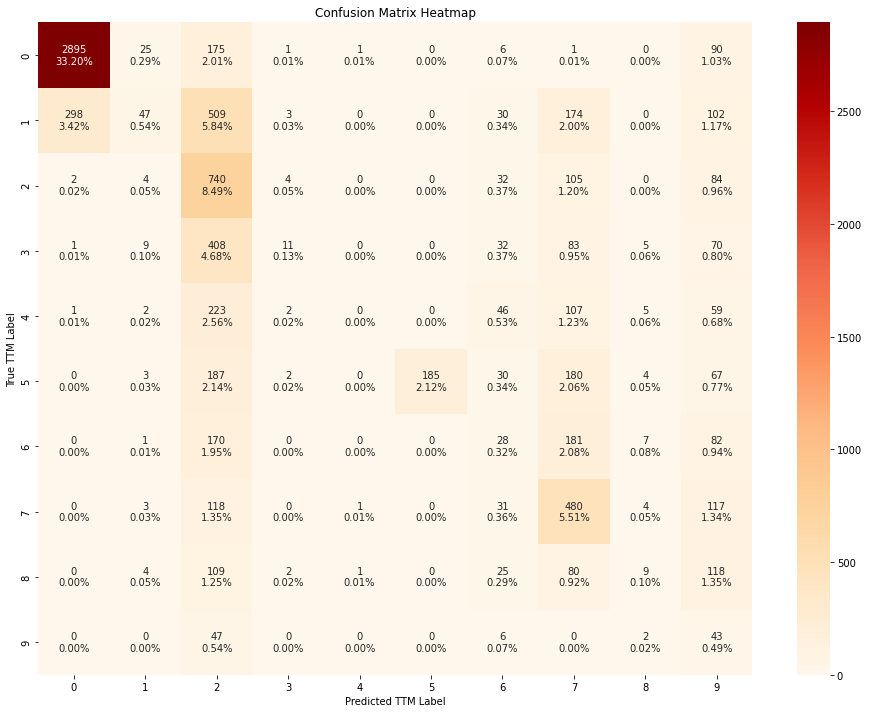

In [52]:
train_evaluate_classifier(
    gnb, X_train_scaled_pruned, y_train, X_test_scaled_pruned, y_test
)

#### SVM

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      3194
           1       0.59      0.33      0.42      1163
           2       0.34      0.71      0.46       971
           3       0.31      0.20      0.24       619
           4       0.50      0.12      0.19       445
           5       0.61      0.53      0.57       658
           6       0.45      0.41      0.43       469
           7       0.75      0.57      0.65       754
           8       0.29      0.27      0.28       348
           9       0.35      0.07      0.12        98

    accuracy                           0.63      8719
   macro avg       0.51      0.42      0.43      8719
weighted avg       0.63      0.63      0.61      8719



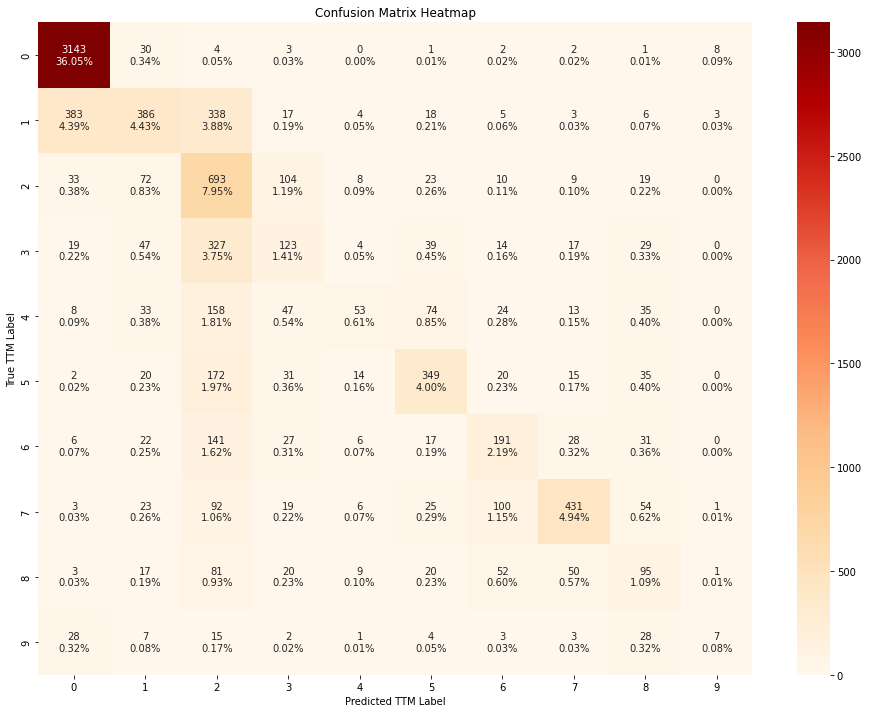

In [53]:
train_evaluate_classifier(
    svc, X_train_scaled_pruned, y_train, X_test_scaled_pruned, y_test
)

#### Random Forest

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3194
           1       0.73      0.76      0.74      1163
           2       0.54      0.57      0.56       971
           3       0.39      0.41      0.40       619
           4       0.47      0.39      0.43       445
           5       0.67      0.66      0.66       658
           6       0.63      0.60      0.61       469
           7       0.78      0.73      0.75       754
           8       0.45      0.48      0.47       348
           9       0.25      0.15      0.19        98

    accuracy                           0.74      8719
   macro avg       0.59      0.57      0.58      8719
weighted avg       0.74      0.74      0.74      8719



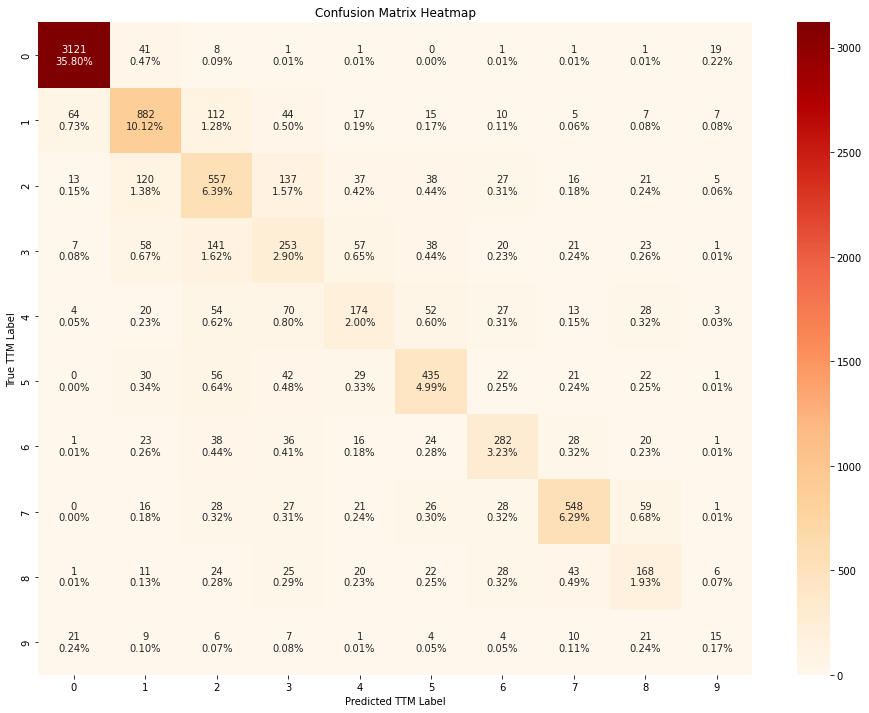

In [54]:
train_evaluate_classifier(
    rf, X_train_scaled_pruned, y_train, X_test_scaled_pruned, y_test
)

#### XGBoost

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3194
           1       0.66      0.75      0.71      1163
           2       0.51      0.65      0.57       971
           3       0.37      0.36      0.37       619
           4       0.62      0.30      0.41       445
           5       0.65      0.60      0.63       658
           6       0.70      0.53      0.60       469
           7       0.80      0.71      0.75       754
           8       0.49      0.51      0.50       348
           9       0.37      0.13      0.20        98

    accuracy                           0.73      8719
   macro avg       0.61      0.55      0.57      8719
weighted avg       0.73      0.73      0.73      8719



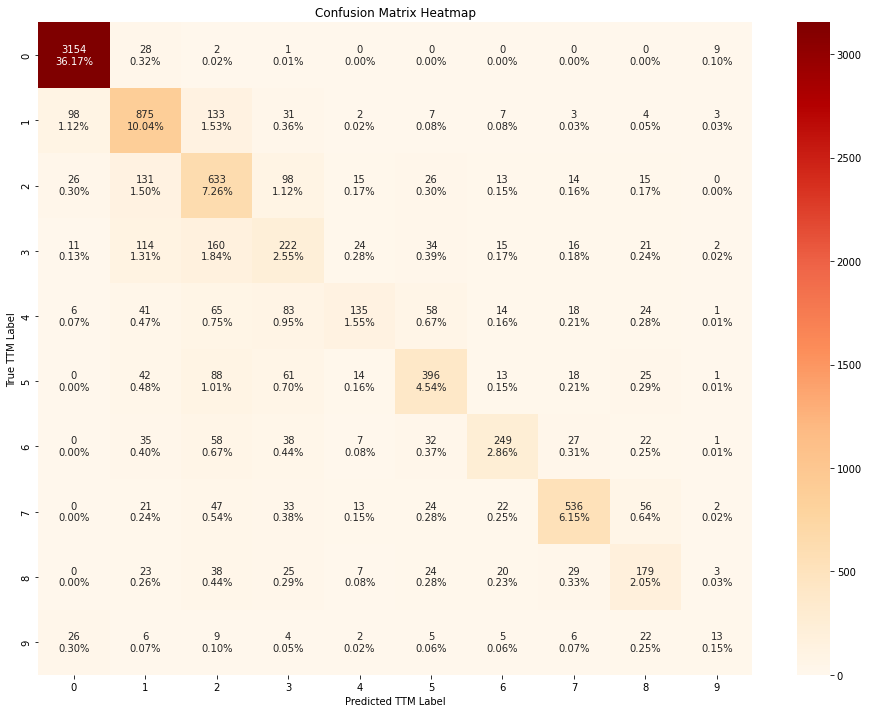

In [55]:
train_evaluate_classifier(
    xgbc, X_train_scaled_pruned, y_train, X_test_scaled_pruned, y_test
)

From the confusion matrices above, we can conclude that the models perform slightly better when trained using only the RFE-pruned subset as compared to all the features. The best model(random forest) performs almost the same, so we will keep all the features for now.

## Create sklearn Pipeline

Here, we will create an sklearn pipeline consisting of 2 steps, scaling of the input features and the classifier itself. We will then save this Pipeline as a `model.joblib` file on S3 for serving the model pipeline using the Seldon Sklearn Server.

In [56]:
pipe = Pipeline(
    steps=[
        ("extract_features", raw_data_processor),
        ("scale", scaler),
        ("rf", selected_model),
    ]
)

In [85]:
pipe2 = Pipeline(
    steps=[
        ("rf", selected_model),
    ]
)

## Write Model to S3

In [58]:
key = "thoth/github-pr-ttm/model"
filename = "model.joblib"
s3_resource = boto3.resource(
    "s3",
    endpoint_url=s3_endpoint_url,
    aws_access_key_id=s3_access_key,
    aws_secret_access_key=s3_secret_key,
)

with tempfile.TemporaryFile() as fp:
    joblib.dump(pipe, fp)
    fp.seek(0)
    s3_obj = s3_resource.Object(s3_bucket, f"{key}/{filename}")
    s3_obj.put(Body=fp.read())

In [86]:
key = "thoth/github-pr-ttm/model-test"
filename = "model-test.joblib"
s3_resource = boto3.resource(
    "s3",
    endpoint_url=s3_endpoint_url,
    aws_access_key_id=s3_access_key,
    aws_secret_access_key=s3_secret_key,
)

with tempfile.TemporaryFile() as fp:
    joblib.dump(pipe2, fp)
    fp.seek(0)
    s3_obj = s3_resource.Object(s3_bucket, f"{key}/{filename}")
    s3_obj.put(Body=fp.read())

In [87]:
## Sanity Check
buffer = BytesIO()
s3_object = s3_resource.Object(s3_bucket, f"{key}/{filename}")
s3_object.download_fileobj(buffer)
model = joblib.load(buffer)
model

Pipeline(steps=[('rf',
                 RandomForestClassifier(max_features=0.75, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

In [161]:
pr_df

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,org,repo,index
43545,214,214,1.0,removed the janusgraph template due to new loc...,this file is now located at https://raw.github...,M,goern,1519911,1520098,fridex,...,{'fridex': 13},{},[],['026ec1a944e25bc8a0db109eff63a708e489b6b2'],['openshift/janusgraph.yaml'],NaN,NaN,thoth-station,core,NaN
43544,213,213,2.0,Download janusgraph template on deployment,Related: #1,XS,fridex,1520098,1520099,fridex,...,"{'fridex': 3, 'goern': 2}",{},[],['ed9b60ab277cc72bd489d4d1fa651561c56b97cf'],"['.gitignore', 'openshift/deploy.sh']",NaN,NaN,thoth-station,core,NaN
43543,212,212,3.0,this is template cleanup and jenkins pipeline,... :),XXL,goern,1521813,1522835,fridex,...,"{'fridex': 102, 'goern': 5}","{'106838621': {'author': 'fridex', 'words_coun...",[],"['ced49067e21ee30d8f77a1003d13e3d01c803855', '...","['.gitignore', 'Jenkinsfile', 'README.rst', 'o...",1970-01-18 14:47:38.236,NaN,thoth-station,core,NaN
43540,209,209,6.0,Respect logging configuration in env variables,NaN,S,fridex,1522998,1524230,sesheta,...,"{'fridex': 15, 'goern': 2}","{'110792359': {'author': 'goern', 'words_count...",['approved'],['d86eab7718d0d180f8435d4082707f5c31b475c9'],"['openshift/configmap-template.yaml', 'openshi...",1970-01-18 15:09:19.370,1970-01-18 15:09:19.370,thoth-station,core,NaN
34520,223,223,2.0,adding OpenShift buildConfig template,NaN,M,goern,1523524,1523690,fridex,...,{},"{'112200224': {'author': 'fridex', 'words_coun...",[],"['f9ecaefa92fa097dc440265dd9584adb6c125dd4', '...",['openshift/buildConfig-template.yaml'],2018-04-14 07:28:17.000,2018-04-14 07:28:17.000,thoth-station,cleanup-job,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35437,1,1,158.0,Fix username in maintainers,## Related Issues and Dependencies\r\n\r\nRela...,XS,mayaCostantini,1653315907,1653316728,harshad16,...,{'sesheta': 73},{},['size/XS'],"['d9463592fdadf859a391606dc36d8bdfc5133964', '...",['OWNERS'],NaN,NaN,thoth-station,prescriptions-refresh-job,NaN
35436,0,0,161.0,Release of version 0.7.0,"Hey, @harshad16!\n\nOpening this PR to create ...",M,khebhut[bot],1653318142,1653318970,sesheta,...,{'sesheta': 327},"{'981924248': {'author': 'sefkhet-abwy[bot]', ...","['bot', 'size/M', 'needs-ok-to-test', 'approve...",['4362562c5d91520fd2aec782c56c474ab664c25a'],"['CHANGELOG.md', 'thoth/prescriptions_refresh/...",2022-05-23 15:02:24,2022-05-23 15:02:24,thoth-station,prescriptions-refresh-job,NaN
1270,2,2,2639.0,added option for starts_with filter on /python...,## Related Issues and Dependencies\r\nhttps://...,S,Gkrumbach07,1653326617,1653391278,mayaCostantini,...,{'sesheta': 85},"{'982657137': {'author': 'mayaCostantini', 'wo...",['size/S'],['ffbaf180aecc5688ccbb1ea08fcc23646f075807'],['thoth/storages/graph/postgres.py'],2022-05-24 06:30:15,2022-05-24 06:30:15,thoth-station,storages,NaN
1268,0,0,2642.0,Release of version 0.72.2,"Hey, @mayaCostantini!\n\nOpening this PR to fi...",XS,khebhut[bot],1653391721,1653392170,mayaCostantini,...,{},{},['bot'],['d23ba576d5d892c74260c44fb855b4029c17c1af'],"['CHANGELOG.md', 'thoth/storages/__init__.py']",NaN,NaN,thoth-station,storages,NaN


In [185]:
sanity_df = pr_df.reindex(X_test.index)

In [186]:
sanity_df

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,org,repo,index
4298,450,450,178.0,Automatic update of dependency thoth-storages ...,Dependency thoth-storages was used in version ...,M,sesheta,1573136911,1573137036,NaN,...,{'ghost': 18},{},['bot'],['650fd49866318df000c2d3e25865e314b41fe4b2'],['Pipfile.lock'],NaN,NaN,thoth-station,metrics-exporter,NaN
13316,6215,6215,4398.0,💊 Package 'django-bitfield' is hosted on GitHub,This change was automatically generated using ...,S,khebhut[bot],1631186,1631186,fridex,...,{},{},['bot'],['f8bdcb1835748e817ee15a7a6e0ca0da9de07407'],['prescriptions/dj_/django-bitfield/gh_link.ya...,NaN,NaN,thoth-station,prescriptions,NaN
46056,1017,1017,765.0,Bump advise reporter stage to v0.5.1,Signed-off-by: Francesco Murdaca <fmurdaca@red...,XS,pacospace,1611132,1611132,sesheta,...,{'sesheta': 65},"{'571991870': {'author': 'fridex', 'words_coun...","['approved', 'size/XS']",['344798e8457a55f84789f3c402e40109bffb2e87'],['advise-reporter/overlays/ocp4-stage/imagestr...,1970-01-19 15:32:12.514,1970-01-19 15:32:12.514,thoth-station,thoth-application,NaN
2540,1272,1272,958.0,PostgreSQL sync package analyzer results,NaN,L,fridex,1568184496,1568189746,NaN,...,"{'todo[bot]': 20, 'ghost': 102, 'fridex': 1}","{'286587429': {'author': 'pacospace', 'words_c...","['approved', 'size/L']","['bfd1d1c6f4c8596fffbcb1e39398f9ddb2562ca9', '...","['.coafile', 'thoth/storages/graph/models.py',...",2019-09-11 06:56:49,2019-09-11 06:56:49,thoth-station,storages,NaN
28650,21549,21549,19155.0,💊 Package 'codacy-coverage' is hosted on GitHub,This change was automatically generated using ...,XS,khebhut[bot],1646133404,1646133676,fridex,...,{},{},['bot'],['0c4bdb6894b40593a47a649cafbb79a8e1db6ec4'],['prescriptions/co_/codacy-coverage/gh_link.ya...,NaN,NaN,thoth-station,prescriptions,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28461,21360,21360,19344.0,💊 Project 'alabaster' has less than 3 maintain...,This change was automatically generated using ...,XS,khebhut[bot],1646134159,1646134767,fridex,...,{},{},"['bot', 'size/XS']",['6ca953b04000c99f670efa511a16ad96fd27b5b0'],['prescriptions/al_/alabaster/pypi_project_mai...,NaN,NaN,thoth-station,prescriptions,NaN
39492,215,215,354.0,Automatic update of dependency thoth-common fr...,Dependency thoth-common was used in version 0....,S,sesheta,1579540470,1579547849,NaN,...,{'ghost': 67},{},"['size/S', 'bot']",['0d784b97b437fade48b0725dbea546f40885f591'],['Pipfile.lock'],NaN,NaN,thoth-station,package-releases-job,NaN
30436,23335,23335,17353.0,💊 Project 'ukpostcodeparser' was not updated f...,This change was automatically generated using ...,S,khebhut[bot],1631829984,1631831148,fridex,...,{'sesheta': 117},{},"['bot', 'size/S', 'needs-ok-to-test']",['7dbad9dbb429131615efb136cad9daf5d6bad972'],['prescriptions/uk_/ukpostcodeparser/gh_update...,NaN,NaN,thoth-station,prescriptions,NaN
45481,442,442,1883.0,Bump adviser to v0.39.0 in stage environment,## Related Issues and Dependencies\r\n\r\nRela...,XS,fridex,1629141,1629354,sesheta,...,"{'fridex': 7, 'sesheta': 65}",{},"['approved', 'size/XS']",['2bd29922e76d1e2b1bc27f5185fb8ba36e5421a6'],['adviser/overlays/ocp4-stage/imagestreamtag.y...,NaN,NaN,thoth-station,thoth-application,NaN


In [187]:
sanity_df_processed = raw_data_processor.transform(sanity_df)

In [188]:
sanity_df_processed

array([[ 2.,  7., 11., ...,  0.,  0.,  0.],
       [ 1., 19.,  1., ...,  0.,  0.,  1.],
       [ 0., 19.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 1., 16.,  9., ...,  0.,  0.,  1.],
       [ 0., 19.,  1., ...,  0.,  0.,  0.],
       [ 1., 19.,  1., ...,  0.,  0.,  1.]])

In [189]:
sanity_df_processed = pd.DataFrame(sanity_df_processed, index=sanity_df.index, columns=cols)

In [190]:
sanity_df_processed

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,num_prev_merged_prs,commits_number,filetype_None,...,title_wordcount_slo,title_wordcount_stage,title_wordcount_toml,title_wordcount_upgrade,title_wordcount_v0,title_wordcount_v1,title_wordcount_v2021,title_wordcount_version,title_wordcount_wip,title_wordcount_💊
4298,2.0,7.0,11.0,3.0,14.0,1.0,14.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13316,1.0,19.0,1.0,0.0,21.0,1.0,23.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
46056,0.0,19.0,1.0,0.0,15.0,2.0,4.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2540,3.0,11.0,9.0,2.0,6.0,3.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28650,0.0,1.0,3.0,1.0,11.0,1.0,23.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28461,0.0,1.0,3.0,1.0,11.0,1.0,23.0,5170.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39492,1.0,20.0,1.0,0.0,17.0,1.0,14.0,1459.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30436,1.0,16.0,9.0,3.0,22.0,1.0,23.0,5171.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45481,0.0,19.0,1.0,0.0,20.0,1.0,7.0,1065.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [201]:
sanity_df_processed.compare(X_test)

num_prev_merged_prs         
                     self    other
4298                  0.0   2860.0
13316                 0.0   4057.0
46056                 0.0    135.0
2540                  0.0   2418.0
28650                 1.0  21571.0
...                   ...      ...
28461              5170.0  21755.0
39492              1459.0   3705.0
30436              5171.0  19235.0
45481              1065.0    656.0
21667              5172.0  12183.0

[8696 rows x 2 columns]

## ^^^ Why is there a difference here?

In [191]:
# lets apply a yeo johnson transform to try to make the data more gaussian
scaler = PowerTransformer()

X_train_scaled = scaler.fit_transform(X_train)
sanity_df_scaled = scaler.transform(sanity_df_processed)
sanity_df_scaled

array([[ 1.03788189, -1.45960785,  1.45665073, ..., -0.23849997,
        -0.02624206, -0.99997133],
       [ 0.09929613,  0.27447719, -0.96751159, ..., -0.23849997,
        -0.02624206,  1.00002867],
       [-1.53366115,  0.27447719, -0.96751159, ..., -0.23849997,
        -0.02624206, -0.99997133],
       ...,
       [ 0.09929613, -0.20418875,  1.31401938, ..., -0.23849997,
        -0.02624206,  1.00002867],
       [-1.53366115,  0.27447719, -0.96751159, ..., -0.23849997,
        -0.02624206, -0.99997133],
       [ 0.09929613,  0.27447719, -0.96751159, ..., -0.23849997,
        -0.02624206,  1.00002867]])

In [192]:
X_test_scaled

array([[ 1.03788189, -1.45960785,  1.45665073, ..., -0.23849997,
        -0.02624206, -0.99997133],
       [ 0.09929613,  0.27447719, -0.96751159, ..., -0.23849997,
        -0.02624206,  1.00002867],
       [-1.53366115,  0.27447719, -0.96751159, ..., -0.23849997,
        -0.02624206, -0.99997133],
       ...,
       [ 0.09929613, -0.20418875,  1.31401938, ..., -0.23849997,
        -0.02624206,  1.00002867],
       [-1.53366115,  0.27447719, -0.96751159, ..., -0.23849997,
        -0.02624206, -0.99997133],
       [ 0.09929613,  0.27447719, -0.96751159, ..., -0.23849997,
        -0.02624206,  1.00002867]])

In [195]:
diff = sanity_df_scaled - X_test_scaled
diff

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [197]:
np.all(diff==0)
np.nonzero(diff)

(array([   0,    1,    2, ..., 8716, 8717, 8718]),
 array([7, 7, 7, ..., 7, 7, 7]))

In [64]:
# take raw pr data and predict ttm classes
preds = model.predict(pr_df.reindex(X_test.index))
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      3194
           1       0.18      0.21      0.20      1163
           2       0.33      0.42      0.37       971
           3       0.19      0.23      0.20       619
           4       0.24      0.24      0.24       445
           5       0.12      0.07      0.09       658
           6       0.25      0.17      0.20       469
           7       0.41      0.21      0.28       754
           8       0.22      0.29      0.25       348
           9       0.20      0.06      0.09        98

    accuracy                           0.48      8719
   macro avg       0.30      0.28      0.28      8719
weighted avg       0.48      0.48      0.48      8719



In [199]:
# take raw pr data and predict ttm classes
preds = model.predict(X_test_scaled)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3194
           1       0.73      0.75      0.74      1163
           2       0.54      0.57      0.56       971
           3       0.38      0.40      0.39       619
           4       0.47      0.39      0.43       445
           5       0.66      0.65      0.66       658
           6       0.64      0.61      0.62       469
           7       0.76      0.73      0.74       754
           8       0.44      0.46      0.45       348
           9       0.28      0.16      0.21        98

    accuracy                           0.74      8719
   macro avg       0.59      0.57      0.58      8719
weighted avg       0.73      0.74      0.73      8719



In [198]:
# take raw pr data and predict ttm classes
preds = model.predict(sanity_df_scaled)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      3194
           1       0.18      0.21      0.20      1163
           2       0.33      0.42      0.37       971
           3       0.19      0.23      0.20       619
           4       0.24      0.24      0.24       445
           5       0.12      0.07      0.09       658
           6       0.25      0.17      0.20       469
           7       0.41      0.21      0.28       754
           8       0.22      0.29      0.25       348
           9       0.20      0.06      0.09        98

    accuracy                           0.48      8719
   macro avg       0.30      0.28      0.28      8719
weighted avg       0.48      0.48      0.48      8719



## Conclusion

In this notebook, we explored various vanilla classifiers, namely, Naive Bayes, SVM, Random Forests, and XGBoost. The Random Forest classifier was able to predict the classes with a weighted average f1 score of 0.73 an accuracy of 74% when trained using all the available features.

Even though all models outperform the baseline (random guess), we believe there is still some room for improvement. Since the target variable of the github PR dataset is an ordinal variable, an ordinal classifier could perform better than the models trained in this notebook. 

As the immediate next step, we will to deploy the best model from this notebook as an inference service using Seldon.